In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


## Helper functions

For visulalisation purposes

In [2]:
def imshow(img, text = None, should_save = False):
    npimg = img.numpy()
    plt.axis("off")
    if text is not None:
        plt.text(75, 8,text, style = 'italic', fontweight = 'bold',bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg ,(1,2,0))) #permute the axis and show them
    plt.show()

def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()
        

## Configuration Function

Change here for a global effect

In [24]:
class Config():
    training_dir = './data/train'
    testing_dir = './data/test'
    saving_dir = './MODEL'
    train_batch_size = 128 #change this according to requirement
    train_number_epochs = 20 #change this according to requirement

## Dataset Class

Returns two images and a label.

Label 0 - if both images belong to similar class
Label 1 - if they belong to different class

In [4]:
class SiameseMNIST(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}
        else:
            # generate fixed pairs for testing
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                               1]
                              for i in range(0, len(self.test_data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.test_data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            target = np.random.randint(0, 2)
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            if target == 1:
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.train_data[siamese_index]
        else:
            img1 = self.test_data[self.test_pairs[index][0]]
            img2 = self.test_data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return (img1, img2), target

    def __len__(self):
        return len(self.mnist_dataset)

In [5]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

In [6]:
pytorch_mnist_train_dataset = dset.MNIST(root= '.', train=True, transform=trans,download=True)
pytorch_mnist_test_dataset = dset.MNIST(root = '.', train=False, transform=trans,download=True)

In [7]:
pytorch_mnist_train_dataset

#output of dset.MNIST function of dset gives a tuple
#The the first [] indicates what image is chosen
#the second [] [0] shows the image itself , [][1] shows the integer label of the class assigned by pytorch

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: .
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(1.0,))
                         )
    Target Transforms (if any): None

In [8]:
pytorch_mnist_test_dataset


Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: .
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(1.0,))
                         )
    Target Transforms (if any): None

In [9]:
#translating the dataset to make it ready for siamese dataset
mnist_train_dataset = SiameseMNIST(pytorch_mnist_train_dataset)
print("The length of training dataset is: {}".format(len(mnist_train_dataset)))

The length of training dataset is: 60000


In [10]:
mnist_test_dataset = SiameseMNIST(pytorch_mnist_test_dataset)
print("The length of testing dataset is: {}".format(len(mnist_test_dataset)))

The length of testing dataset is: 10000


## Visualising the data



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of IMG0 in a batch: 8
Number of IMG1 in a batch: 8
Number of labels in a batch: 8
B * CHANNELS * DIMENSIONS for IMG0: torch.Size([8, 1, 28, 28])
B * CHANNELS * DIMENSIONS for IMG1: torch.Size([8, 1, 28, 28])
DIMENSIONS of IMG0: torch.Size([1, 28, 28])
DIMENSIONS of IMG1: torch.Size([1, 28, 28])
torch.Size([16, 1, 28, 28])


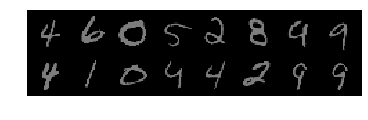

tensor([1, 0, 1, 0, 0, 0, 1, 1])


Process Process-4:
Process Process-2:
Process Process-3:
Process Process-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/

In [11]:
#TRAINING DATA BATCH
vis_dataloader = DataLoader(mnist_train_dataset,
                           shuffle = True,
                           num_workers = 4,
                           batch_size = 8) #load the dataset

dataiter = iter(vis_dataloader)

first_batch_train = next(dataiter)


print("Number of IMG0 in a batch: {}".format(len(first_batch_train[0][0])))
print("Number of IMG1 in a batch: {}".format(len(first_batch_train[0][1])))
print("Number of labels in a batch: {}".format(len(first_batch_train[1])))
print("B * CHANNELS * DIMENSIONS for IMG0: {}".format(first_batch_train[0][0].size()))
print("B * CHANNELS * DIMENSIONS for IMG1: {}".format(first_batch_train[0][1].size()))
print("DIMENSIONS of IMG0: {}".format(first_batch_train[0][0][1].size()))
print("DIMENSIONS of IMG1: {}".format(first_batch_train[0][1][1].size()))
concatenated = torch.cat((first_batch_train[0][0], first_batch_train[0][1]), 0) #concatenate both batches = total sixteen images (including img1 and img2)
print(concatenated.size())
imshow(torchvision.utils.make_grid(concatenated))
print(first_batch_train[1]) #shows one for similar and 0 for dissimilar



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of IMG0 in a batch: 8
Number of IMG1 in a batch: 8
Number of labels in a batch: 8
B * CHANNELS * DIMENSIONS for IMG0: torch.Size([8, 1, 28, 28])
B * CHANNELS * DIMENSIONS for IMG1: torch.Size([8, 1, 28, 28])
DIMENSIONS of IMG0: torch.Size([1, 28, 28])
DIMENSIONS of IMG1: torch.Size([1, 28, 28])
torch.Size([16, 1, 28, 28])


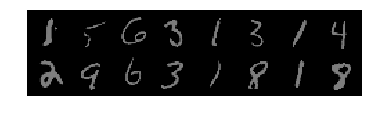

tensor([0, 0, 1, 1, 1, 0, 1, 0])


Process Process-7:
Process Process-8:
Process Process-6:
Process Process-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", li

In [12]:
#TESTING DATA BATCH
vis_dataloader = DataLoader(mnist_test_dataset,
                           shuffle = True,
                           num_workers = 4,
                           batch_size = 8) #load the dataset

dataiter_test = iter(vis_dataloader)

first_batch_test = next(dataiter_test)


print("Number of IMG0 in a batch: {}".format(len(first_batch_test[0][0])))
print("Number of IMG1 in a batch: {}".format(len(first_batch_test[0][1])))
print("Number of labels in a batch: {}".format(len(first_batch_test[1])))
print("B * CHANNELS * DIMENSIONS for IMG0: {}".format(first_batch_test[0][0].size()))
print("B * CHANNELS * DIMENSIONS for IMG1: {}".format(first_batch_test[0][1].size()))
print("DIMENSIONS of IMG0: {}".format(first_batch_test[0][0][1].size()))
print("DIMENSIONS of IMG1: {}".format(first_batch_test[0][1][1].size()))
concatenated = torch.cat((first_batch_test[0][0], first_batch_test[0][1]), 0) #concatenate both batches = total sixteen images (including img1 and img2)
print(concatenated.size())
imshow(torchvision.utils.make_grid(concatenated))
print(first_batch_test[1]) #shows one for similar and 0 for dissimilar




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The label 0 indicates IMAGES FROM SAME CLASS and 1 indicates IMAGES FROM DIFFERENT CLASS


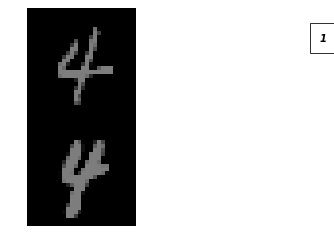

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


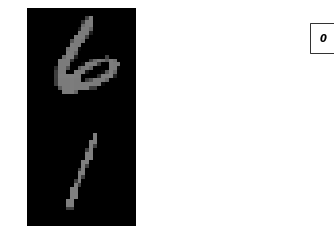

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


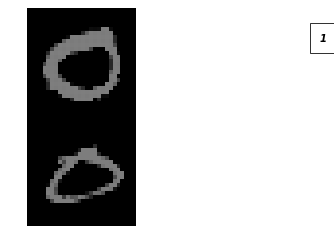

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


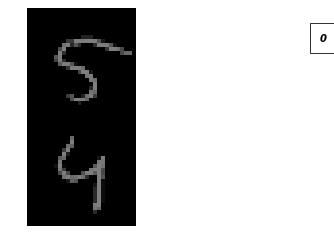

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


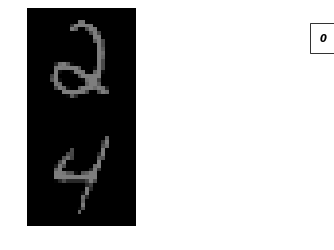

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


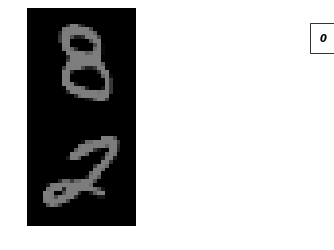

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


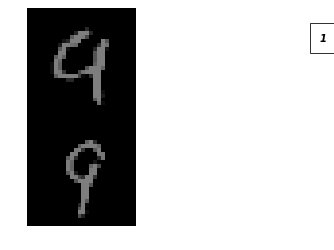

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


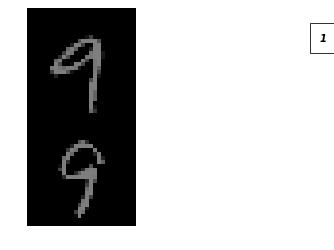

In [13]:
# second way of visualising train dataset

print("The label 0 indicates IMAGES FROM SAME CLASS and 1 indicates IMAGES FROM DIFFERENT CLASS")
for i in range(len(first_batch_train[0][0])):
    #print image tuples of first batch
    cat = torch.cat((first_batch_train[0][0][i].squeeze(), first_batch_train[0][1][i].squeeze()), 0)
    imshow(torchvision.utils.make_grid(cat), text = str(first_batch_train[1][i].numpy()))

# Neural Net Definition

In [14]:
class SiameseNeuralNetwork(nn.Module):
    def __init__(self):
        super(SiameseNeuralNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size = 5),
        nn.PReLU(),
        nn.MaxPool2d(2, stride = 2)
        )
        
        self.cnn2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size = 5),
        nn.PReLU(), #parametric relu
        nn.MaxPool2d(2, stride = 2)
        )
        
        self.fc1 = nn.Sequential(
        nn.Linear(64 * 4 * 4, 256),
        nn.PReLU(),
        nn.Linear(256,256),
        nn.PReLU(),
        nn.Linear(256,2)
        )
        
    
    def forward_once(self, x):
        output = self.cnn1(x)
        output = self.cnn2(output)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output
    
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss


In [15]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()


# Training Phase

In [16]:
train_dataloader = DataLoader(mnist_train_dataset,
                             shuffle=True,
                             num_workers=4,
                             batch_size = Config.train_batch_size)

In [17]:
margin = 1.
net = SiameseNeuralNetwork()
criterion = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(net.parameters(), lr = lr)

In [18]:
counter = []
loss_list = []
iteration_number = 0

Epoch 0 Running
Epoch Number: 0 Current Loss: 0.232558935880661
Epoch Number: 0 Current Loss: 0.05124713107943535
Epoch Number: 0 Current Loss: 0.0521305687725544
Epoch Number: 0 Current Loss: 0.043987859040498734
Epoch Number: 0 Current Loss: 0.0397757813334465
Epoch 1 Running
Epoch Number: 1 Current Loss: 0.02606683038175106
Epoch Number: 1 Current Loss: 0.021421518176794052
Epoch Number: 1 Current Loss: 0.024586671963334084
Epoch Number: 1 Current Loss: 0.02165883779525757
Epoch Number: 1 Current Loss: 0.011715095490217209
Epoch 2 Running
Epoch Number: 2 Current Loss: 0.010111229494214058
Epoch Number: 2 Current Loss: 0.01220673881471157
Epoch Number: 2 Current Loss: 0.011940514668822289
Epoch Number: 2 Current Loss: 0.0068270545452833176
Epoch Number: 2 Current Loss: 0.010257483460009098
Epoch 3 Running
Epoch Number: 3 Current Loss: 0.004829504992812872
Epoch Number: 3 Current Loss: 0.007642331533133984
Epoch Number: 3 Current Loss: 0.006550301797688007
Epoch Number: 3 Current Loss

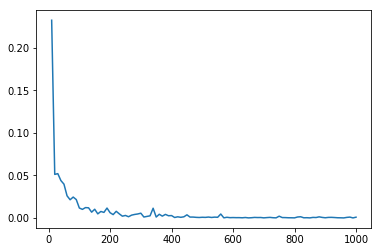

In [22]:
for epoch in range(Config.train_number_epochs):
    print("Epoch {} Running".format(epoch))
    for i, data in enumerate(train_dataloader, 0):
        imgs, label = data
        optimizer.zero_grad()
        output1, output2 = net(imgs[0], imgs[1])
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        if i % 100 == 0:
            print("Epoch Number: {} Current Loss: {}".format(epoch,loss_contrastive.item()))
            iteration_number += 10
            counter.append(iteration_number)
            loss_list.append(loss_contrastive.item())
            
show_plot(counter, loss_list)

## SAVING MODEL

In [25]:

torch.save(net, Config.saving_dir)

/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseNeuralNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# LOADING MODEL

In [26]:
model = torch.load(Config.saving_dir)

# Validation

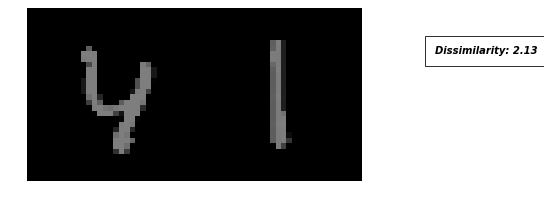

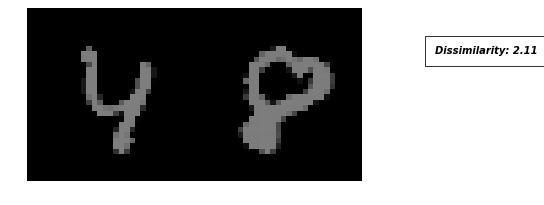

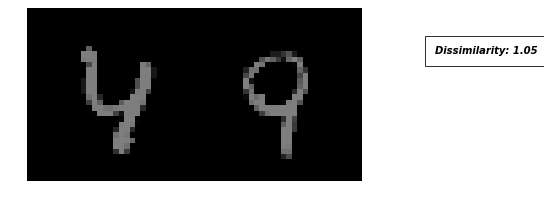

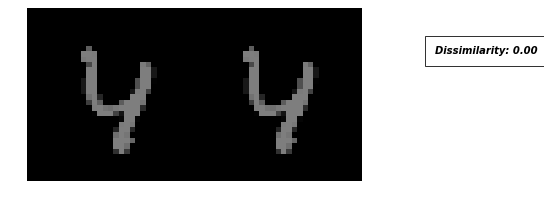

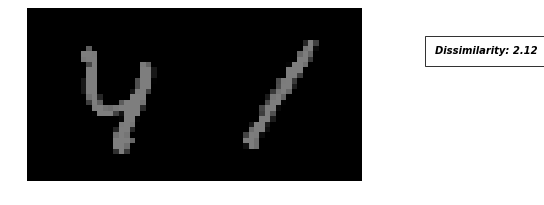

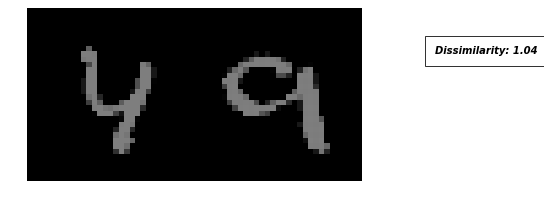

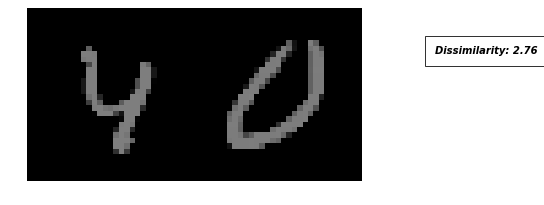

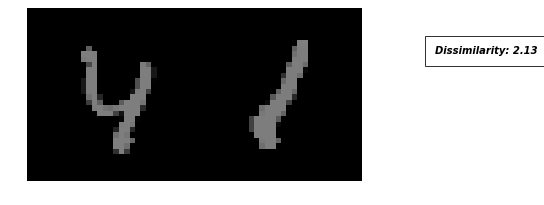

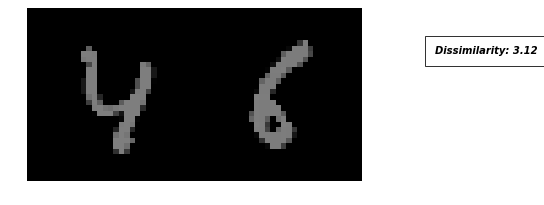

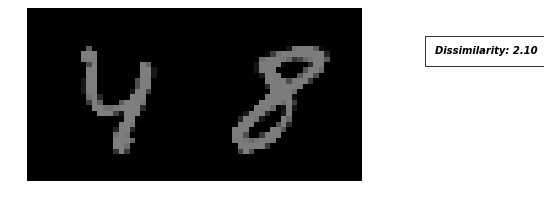

In [34]:
test_dataloader = DataLoader(mnist_test_dataset,num_workers=4,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
imgs,_ = next(dataiter)
x0 = imgs[0]

for i in range(10):
    imgs,label2 = next(dataiter)
    x1 = imgs[1]
    concatenated = torch.cat((x0,x1),0)    
    output1,output2 = model(Variable(x0),Variable(x1))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))


